# Predicción del abandono de clientes en Beta Bank

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba.

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

# Descripción de los datos

Características:

- `RowNumber` - índice de cadena de datos
- `CustomerId` - identificador de cliente único
- `Surname` - apellido
- `CreditScore` - valor de crédito
- `Geography` - país de residencia
- `Gender` - sexo
- `Age` - edad
- `Tenure` - período durante el cual ha madurado el depósito a plazo fijo de un cliente (años)
- `Balance` - saldo de la cuenta
- `NumOfProducts` - número de productos bancarios utilizados por el cliente
- `HasCrCard` - el cliente tiene una tarjeta de crédito (1 - sí; 0 - no)
- `IsActiveMember` - actividad del cliente (1 - sí; 0 - no)
- `EstimatedSalary` - salario estimado


# Inicialización

In [371]:
# Carga todas las librerías
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Cargar los datos

In [372]:
# Carga los datos en DataFrames
try:
    df = pd.read_csv('/datasets/Churn.csv')
except Exception:
    df = pd.read_csv('datasets/Churn.csv')

# Preparar los datos

In [373]:
# Imprime la información general/resumen sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [374]:
# Imprime una muestra aleatoria de 5 filas del DataFrame
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
8224,8225,15804937,Cambage,702,France,Male,50,3.0,0.00,2,0,0,94949.84,0
4265,4266,15810454,Reed,709,France,Male,32,4.0,147307.91,1,0,1,40861.55,0
7097,7098,15664793,Scott,754,Spain,Female,50,7.0,146777.44,2,0,1,150685.52,0
5779,5780,15723950,Kruglov,684,Spain,Male,40,2.0,70291.02,1,1,1,115468.84,1
7696,7697,15679453,Hung,614,Germany,Female,39,NaN,125997.22,1,1,1,128049.34,1


## Observaciones
- La columna `Tenure` tiene al rededor del 10% de valores ausentes. 
- Las columnas `RowNumber`, `CustomerId` y `Surname` no contienen información relevante para las predicciones del modelo.

## Eliminar columnas innecesarias

In [375]:
# Elimina las columnas que no se utilizarán en el análisis
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

## Imputar datos

<Axes: >

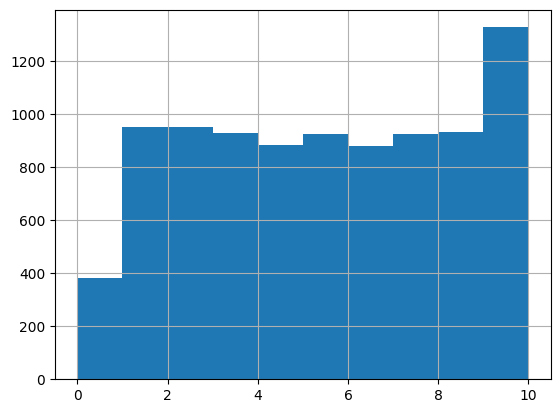

In [376]:
# Verificar si la columna 'Tenure' tiene una distribución normal
df['Tenure'].hist(bins=10)

## Observaciones
- La columna `Tenure` no muestra una distribución normal por lo que se decide utilizar la mediana para imputar los datos ausentes.

In [377]:
# Imputa los valores faltantes en la columna Tenure con la mediana
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [378]:
# Imprime la información general/resumen sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


## Transformar datos

In [379]:
# Crea una lista de las columnas que son de tipo object
object_columns = list(df.select_dtypes(include=['object']).columns)

# Imprime la lista de columnas que son de tipo object
print(object_columns)

['Geography', 'Gender']


In [380]:
# Codifica sólo las variables categóricas (columnas tipo object) con one-hot encoding
df = pd.get_dummies(df, columns=object_columns, drop_first=True)

# Imprime la información general/resumen sobre el DataFrame
df.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [381]:
# Imprime la información general/resumen sobre el DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.6 KB


In [382]:
# Cambia el tipo de datos de las columnas binarias a uint8
df['HasCrCard'] = df['HasCrCard'].astype('uint8')
df['IsActiveMember'] = df['IsActiveMember'].astype('uint8')
df['Exited'] = df['Exited'].astype('uint8')

In [383]:
# Crea una lista de las columnas que son de tipo numérico
numeric_columns = list(df.select_dtypes(include=['float64', 'int64']).columns)

# Imprime la lista de columnas que son de tipo numérico
print(numeric_columns)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


In [384]:
# Normaliza las variables numéricas
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Imprime una muestra aleatoria de 5 filas del DataFrame
df.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
2148,-0.212407,-1.232140,0.725432,-1.225848,0.807737,1,1,-1.624717,0,0,1,1
4667,1.018859,1.437761,-0.723910,1.094380,-0.911583,1,0,-0.117444,1,1,0,1
1921,0.077303,-0.373958,0.000761,0.799941,-0.911583,0,0,0.978502,1,0,0,0
8805,2.063884,0.007457,1.087768,-1.225848,0.807737,1,1,-1.095504,0,0,1,1
3987,-0.181367,-0.183251,0.000761,1.042731,-0.911583,1,1,0.430202,0,0,0,1


# Segmentar los datos

In [385]:
# Seleccionar un seed aleatorio para los experimentos
random_state = 12345

In [386]:
# Divide el DataFrame en características (features) y objetivo (target)
features = df.drop(['Exited'], axis=1)
target = df['Exited']

In [387]:
# Separar los datos en subconjuntos de entrenamiento, validación y prueba (3:1:1)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.4, random_state=random_state)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=random_state)

# Equilibrio de clases

0    0.800667
1    0.199333
Name: Exited, dtype: float64


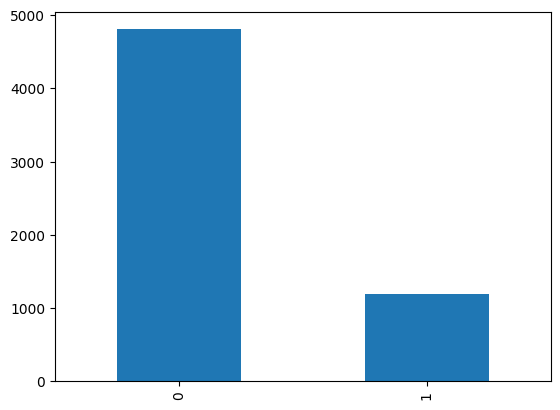

In [388]:
# Examina el equilibrio de clases mediante un gráfico de barras
target_train.value_counts().plot(kind='bar')

# Imprime el porcentaje de valores de la clase positiva y negativa en el conjunto de entrenamiento
print(target_train.value_counts(normalize=True))


## Observaciones
- `Exited`, la cual es la columna objetivo, tiene un claro desequilibrio de clases (al rededor del 80% está concentrado en uno de los dos valores posibles).

## Probar el modelo desequilibrado

In [389]:
# Crear función de entrenamiento y evaluación de modelos
def train_evaluate_model(model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_valid)
    return f1, auc_roc

In [390]:
# Entrena y evalúa un modelo de regresión logística con los datos desequilibrados
model = LogisticRegression(random_state=random_state, solver='liblinear')
f1, auc_roc = train_evaluate_model(model, features_train, target_train, features_valid, target_valid)
print('F1:', f1)
print('AUC-ROC:', auc_roc)

F1: 0.33108108108108103
AUC-ROC: 0.7587497504824008


## Conclusion intermedia
-  El modelo tiene un desempeño medio en términos de la puntuación `AUC-ROC`. Sin embargo, el puntaje `F1` es bastante bajo. Esto sugiere que el modelo podría no estar prediciendo bien la clase minoritaria.
- Será necesario aplicar submuestreo y sobremuestreo para solucionar el desequilibrio de los datos.

## Submuestreo

In [391]:
# Crear función de submuestreo (downsampling)
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=random_state)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=random_state)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=random_state
    )

    return features_downsampled, target_downsampled

In [392]:
# Probar la función de submuestreo
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

# Imprimir el balance de clases después de aplicar la función de submuestreo
print(target_downsampled.value_counts(normalize=True))

0    0.501043
1    0.498957
Name: Exited, dtype: float64


## Sobremuestreo

In [393]:
# Crear función de sobremuestreo (upsampling)
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=random_state
    )

    return features_upsampled, target_upsampled

In [394]:
# Probar la función de sobremuestreo
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

# Imprimir el balance de clases después de aplicar la función de sobremuestreo
print(target_upsampled.value_counts(normalize=True))

0    0.501043
1    0.498957
Name: Exited, dtype: float64


# Entrenamiento del modelo

## Regresión logística

In [395]:
# Probar el modelo de Regresión Logística con el conjunto de entrenamiento con submuestreo
model = LogisticRegression(random_state=random_state, solver='liblinear')
f1, auc_roc = train_evaluate_model(model, features_downsampled, target_downsampled, features_valid, target_valid)
print('F1:', f1)
print('AUC-ROC:', auc_roc)


F1: 0.48406546080964685
AUC-ROC: 0.7622913881646999


In [396]:
# Probar el modelo de Regresión Logística con el conjunto de entrenamiento con sobremuestreo
model = LogisticRegression(random_state=random_state, solver='liblinear')
f1, auc_roc = train_evaluate_model(model, features_upsampled, target_upsampled, features_valid, target_valid)
print('F1:', f1)
print('AUC-ROC:', auc_roc)

F1: 0.4888507718696398
AUC-ROC: 0.7636478565682105


## Árbol de decisión

In [397]:
# Probar el modelo de Árbol de Decisión con el conjunto de entrenamiento con submuestreo
best_depth = 5
model = DecisionTreeClassifier(random_state=random_state, max_depth=best_depth)
f1, auc_roc = train_evaluate_model(model, features_downsampled, target_downsampled, features_valid, target_valid)
print('F1:', f1)
print('AUC-ROC:', auc_roc)

F1: 0.5943204868154158
AUC-ROC: 0.8241029464247908


In [398]:
# Probar el modelo de Árbol de Decisión con el conjunto de entrenamiento con sobremuestreo
best_depth = 5
model = DecisionTreeClassifier(random_state=random_state, max_depth=best_depth)
f1, auc_roc = train_evaluate_model(model, features_upsampled, target_upsampled, features_valid, target_valid)
print('F1:', f1)
print('AUC-ROC:', auc_roc)


F1: 0.5963791267305644
AUC-ROC: 0.8310244134068074


## Bosque aleatorio

In [399]:
# Probar el modelo de Bosque Aleatorio con el conjunto de entrenamiento con submuestreo
best_est = 16
model = RandomForestClassifier(random_state=random_state, n_estimators=best_est)
f1, auc_roc = train_evaluate_model(model, features_downsampled, target_downsampled, features_valid, target_valid)
print('F1:', f1)
print('AUC-ROC:', auc_roc)

F1: 0.598825831702544
AUC-ROC: 0.8419653820794947


In [400]:
# Probar el modelo de Bosque Aleatorio con el conjunto de entrenamiento con sobremuestreo
best_est = 89
model = RandomForestClassifier(random_state=random_state, n_estimators=best_est)
f1, auc_roc = train_evaluate_model(model, features_upsampled, target_upsampled, features_valid, target_valid)
print('F1:', f1)
print('AUC-ROC:', auc_roc)

F1: 0.6137841352405721
AUC-ROC: 0.8382770582933601


## Conclusion intermedia
- El modelo con mejor puntuación F1 fue `RandomForestClassifier` con `n_estimators = 89` y utilizando el conjunto de entrenamiento con `sobremuestreo`.

**NOTA**: Los valores para `max_depth` y `n_estimators` se obtuvieron mediante pruebas con valores entre `1 - 100`.

# Comprobar la calidad del modelo

In [401]:
# Modelo de Bosque Aleatorio con el conjunto de entrenamiento con sobremuestreo y el conjunto de prueba
model = RandomForestClassifier(random_state=random_state, n_estimators=89)
f1, auc_roc = train_evaluate_model(model, features_upsampled, target_upsampled, features_test, target_test)
print('F1:', f1)
print('AUC-ROC:', auc_roc)

F1: 0.5948051948051948
AUC-ROC: 0.8446619625197317


## Prueba de consistencia

In [402]:
# Crea un dummy classifier que siempre predice la clase más frecuente
dummy = DummyClassifier(strategy='most_frequent', random_state=random_state)
f1, auc_roc = train_evaluate_model(dummy, features_upsampled, target_upsampled, features_test, target_test)
print('F1:', f1)
print('AUC-ROC:', auc_roc)

F1: 0.0
AUC-ROC: 0.5


## Conclusion intermedia

- El `F1-score` de `Dummy Classifier` es 0 porque siempre predice la clase mayoritaria.
- El `AUC-ROC` de `Dummy Classifier` es 0.5, lo que indica que no tiene capacidad para distinguir entre las clases, es como adivinar al azar.

# Conclusión general

Los modelos de clasificación probados incluyeron el `regresión logística`, `árbol de decisión` y `bosque aleatorio`. Para hacer frente al desequilibrio de las clases en el conjunto de datos, se implementaron métodos de sobremuestreo y submuestreo. El análisis reveló que:

- El modelo de `regresión logística` tuvo la menor puntuación `F1`, aunque fue el más rápido en términos de tiempo de ejecución.
- El modelo de `árbol de decisión`, a pesar de tener un mejor rendimiento que la regresión logística, no logró superar a los demás modelos en términos de puntuación `F1`.
- El modelo de `bosque aleatorio`, con `n_estimators` ajustado a `89`, demostró la puntuación `F1` más alta (**`0.5948`**), aunque requirió el mayor tiempo de ejecución.

Estos resultados destacan la eficacia del bosque aleatorio en este conjunto de datos y la importancia de técnicas como el sobremuestreo para abordar los desafíos planteados por el desequilibrio de clases.
